# Differential Expression with limma-voom pipeline

In [1]:
suppressMessages({library(SummarizedExperiment)
                  library(tidyverse)
                  library(limma)
                  library(edgeR)
                  library(sva)})

## Functions

### Simple functions

In [2]:
# Function from jaffelab github
merge_rse_metrics <- function(rse) {
    stopifnot(is(rse, 'RangedSummarizedExperiment'))

    rse$overallMapRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$overallMapRate, rse$numReads)
    rse$mitoRate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$mitoRate, rse$numMapped)
    rse$rRNA_rate = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$rRNA_rate, rse$numMapped)
    rse$totalAssignedGene = mapply(function(r, n) {
        sum(r*n)/sum(n)
    }, rse$totalAssignedGene, rse$numMapped)

    rse$numMapped = sapply(rse$numMapped, sum)
    rse$numReads = sapply(rse$numReads, sum)
    rse$numUnmapped = sapply(rse$numUnmapped, sum)
    rse$mitoMapped = sapply(rse$mitoMapped, sum)
    rse$totalMapped = sapply(rse$totalMapped, sum)
    return(rse)
}


save_volcanoPlot <- function(top, label, feature){
    pdf(file=paste0(feature, "/volcanoPlot_", label, ".pdf"), 8, 6)
    with(top, plot(logFC, -log10(P.Value), pch=20, cex=0.6))
    with(subset(top, adj.P.Val<=0.05), points(logFC, -log10(P.Value),
                                              pch=20, col='red', cex=0.6))
    with(subset(top, abs(logFC)>0.50), points(logFC, -log10(P.Value),
                                              pch=20, col='orange', cex=0.6))
    with(subset(top, adj.P.Val<=0.05 & abs(logFC)>0.50),
         points(logFC, -log10(P.Value), pch=20, col='green', cex=0.6))
    dev.off()
}


save_MAplot <- function(top, label, feature){
    pdf(file=paste0(feature, "/MAplot_", label, ".pdf"), 8, 6)
    with(top, plot(AveExpr, logFC, pch=20, cex=0.5))
    with(subset(top, adj.P.Val<0.05),
         points(AveExpr, logFC, col="red", pch=20, cex=0.5))
    dev.off()
}


extract_de <- function(contrast, label, efit, feature){
    top <- topTable(efit, coef=contrast, number=Inf, sort.by="P")
    top <- top[order(top$P.Value), ]
    top.fdr <- top %>% filter(adj.P.Val<=0.05)
    print(paste("Comparison for:", label))
    print(paste('There are:', dim(top.fdr)[1], 'DE features!'))
    data.table::fwrite(top, file=paste0(feature, "/diffExpr_", label, "_full.txt"), 
                       sep='\t', row.names=TRUE)
    data.table::fwrite(top.fdr, file=paste0(feature, "/diffExpr_", label, "_FDR05.txt"), 
                       sep='\t', row.names=TRUE)
    save_volcanoPlot(top, label, feature)
    save_MAplot(top, label, feature)
}


### Cached functions

In [3]:
get_mds <- function(){
    mds_file = "/ceph/projects/v4_phase3_paper/inputs/genotypes/mds/_m/LIBD_Brain_TopMed.mds"
    mds = data.table::fread(mds_file) %>%
        rename_at(.vars = vars(starts_with("C")),
                  function(x){sub("C", "snpPC", x)}) %>%
        mutate_if(is.character, as.factor)
    return(mds)
}

memMDS <- memoise::memoise(get_mds)

prep_data <- function(feature){
    counts_lt = list("genes"="/ceph/projects/v4_phase3_paper/inputs/counts/_m/hippo_brainseq_phase2_hg38_rseGene_merged_n447.rda", 
                     "transcripts"="/ceph/projects/v4_phase3_paper/inputs/counts/_m/hippo_brainseq_phase2_hg38_rseTx_merged_n447.rda",
                     "exons"="/ceph/projects/v4_phase3_paper/inputs/counts/_m/hippo_brainseq_phase2_hg38_rseExon_merged_n447.rda",
                     "junctions"="/ceph/projects/v4_phase3_paper/inputs/counts/_m/hippo_brainseq_phase2_hg38_rseJxn_merged_n447.rda")
    tx_file = "/ceph/projects/v4_phase3_paper/inputs/counts/_m/transcripts_counts/hippo_counts.txt"
    load(counts_lt[[feature]])
    if(exists("rse_gene")){
        rse_df = rse_gene
    } else if (exists("rse_tx")){
        counts <- data.table::fread(tx_file) %>% column_to_rownames("transcript_id") %>%
            select(colnames(rse_tx)) %>% as.matrix
        annot <- data.table::fread(tx_file) %>% column_to_rownames("transcript_id") %>%
            select(-starts_with("R"))
        rse_df <- SummarizedExperiment(assays=SimpleList(counts=counts),
                                       rowData=annot, 
                                       colData=colData(rse_tx)) %>%
            as("RangedSummarizedExperiment")
    } else if (exists("rse_exon")){
        rse_df = rse_exon
    } else {
        rse_df = rse_jxn
    }
    keepIndex = which((rse_df$Dx %in% c("Control", "Schizo")) & 
                      rse_df$Age > 17 & rse_df$Sex == "F" &
                      rse_df$Race %in% c("AA", "CAUC"))
    rse_df = rse_df[, keepIndex]
    rse_df$Dx = factor(rse_df$Dx, levels = c("Control", "Schizo"))
    rse_df$Sex <- factor(rse_df$Sex)
    rse_df <- merge_rse_metrics(rse_df)
    colData(rse_df)$RIN = sapply(colData(rse_df)$RIN,"[",1)
    rownames(colData(rse_df)) <- sapply(strsplit(rownames(colData(rse_df)), "_"), "[", 1)
    pheno = colData(rse_df) %>% as.data.frame %>% 
        inner_join(memMDS(), by=c("BrNum"="FID")) %>% 
        distinct(RNum, .keep_all = TRUE) 
    # Generate DGE list
    x <- DGEList(counts=assays(rse_df)$counts[, pheno$RNum], 
                 genes=rowData(rse_df), samples=pheno)
    # Filter by expression
    design0 <- model.matrix(~Dx, data=x$samples)
    keep.x <- filterByExpr(x, design=design0)
    x <- x[keep.x, , keep.lib.sizes=FALSE]
    print(paste('There are:', sum(keep.x), 'features left!', sep=' '))
    # Normalize library size
    x <- calcNormFactors(x, method="TMM")
    return(x)
}

memo_prepData <- memoise::memoise(prep_data)

SVA_model <- function(feature){
    x <- memo_prepData(feature)
    # Design matrix
    mod = model.matrix(~Dx + Age + mitoRate + rRNA_rate + 
                       totalAssignedGene + RIN + overallMapRate + 
                       snpPC1 + snpPC2 + snpPC3, data = x$samples)
    colnames(mod) <- gsub("Dx", "", colnames(mod))
    colnames(mod) <- gsub("\\(Intercept\\)", "Intercept", colnames(mod))
    # Null model
    null.model = mod %>% as.data.frame %>% 
        select(-c("Schizo")) %>% as.matrix
    n.sv <- num.sv(x$counts, mod, method="be")
    ## Fit SVA
    svobj <- svaseq(x$counts, mod, null.model, n.sv=n.sv)
    ## Add to model
    print(paste('Adding SV to design matrix ...', Sys.time(), sep=' '))
    modQsva <- cbind(mod, svobj$sv)
    len.d <- length(colnames(modQsva))
    colnames(modQsva)[((len.d - n.sv)+1):len.d] <- make.names(paste0("sv",1:n.sv))
    return(modQsva)
}

memSVA <- memoise::memoise(SVA_model)

get_voom <- function(feature){
    ### Preform voom
    x <- memo_prepData(feature)
    modQsva <- memSVA(feature)
    v <- voom(x[, rownames(modQsva)], modQsva, plot=TRUE)
    return(v)
}

memo_voom <- memoise::memoise(get_voom)

cal_res <- function(feature){
    ### Calculate residuals
    v <- memo_voom(feature)
    null_model <- v$design %>% as.data.frame %>% 
        select(-c("Schizo")) %>% as.matrix
    fit_res <- lmFit(v, design=null_model)
    res = v$E - ( fit_res$coefficients %*% t(null_model) )
    res_sd = apply(res, 1, sd)
    res_mean = apply(res, 1, mean)
    res_norm = (res - res_mean) / res_sd
    write.table(res_norm, file=paste0(feature, '/residualized_expression.tsv'), 
                sep="\t", quote=FALSE)
}

memo_res <- memoise::memoise(cal_res)

fit_voom <- function(feature){
    v <- memo_voom(feature)
    modQsva <- memSVA(feature)
    fit0 <- lmFit(v, modQsva)
    contr.matrix <- makeContrasts(CtrlvsSZ = Schizo,
                                  levels=colnames(modQsva))
    fit <- contrasts.fit(fit0, contrasts=contr.matrix)
    esv <- eBayes(fit)
    return(esv)
}

memo_efit <- memoise::memoise(fit_voom)

## Differential Expression Analysis

[1] "There are: 22542 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  [1] "Adding SV to design matrix ... 2021-07-13 13:07:10"
[1] "szVctl"
[1] "Comparison for: szVctl"
[1] "There are: 1 DE features!"
[1] "There are: 77450 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  [1] "Adding SV to design matrix ... 2021-07-13 13:09:56"
[1] "szVctl"
[1] "Comparison for: szVctl"
[1] "There are: 0 DE features!"


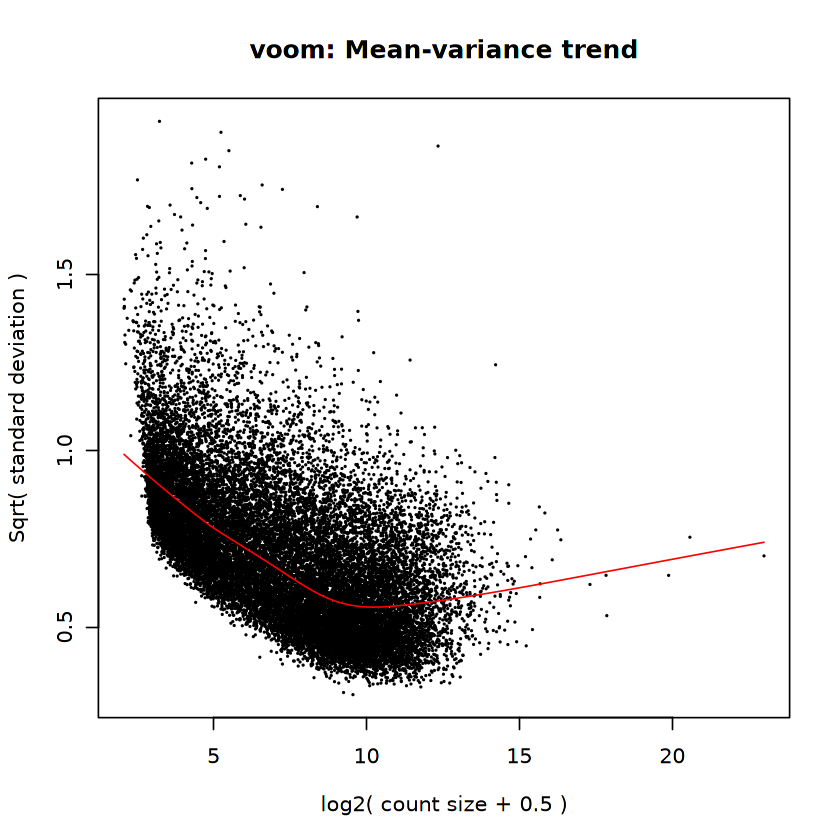

[1] "There are: 138268 features left!"
Number of significant surrogate variables is:  4 
Iteration (out of 5 ):1  2  3  4  5  [1] "Adding SV to design matrix ... 2021-07-13 13:15:18"
[1] "szVctl"
[1] "Comparison for: szVctl"
[1] "There are: 5 DE features!"


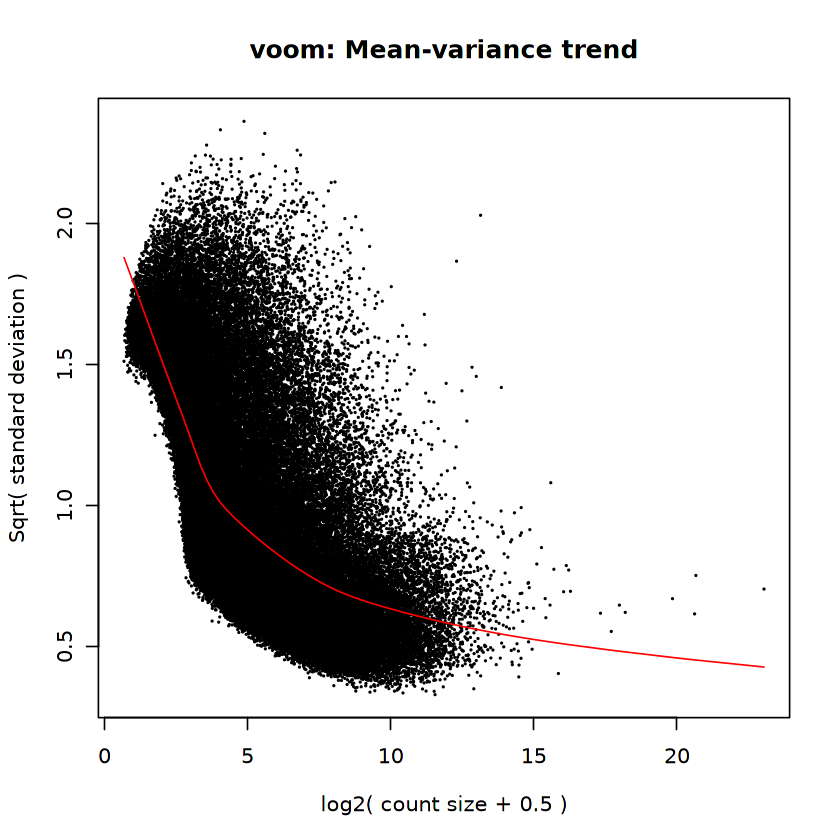

[1] "There are: 330583 features left!"
Number of significant surrogate variables is:  1 
Iteration (out of 5 ):1  2  3  4  5  [1] "Adding SV to design matrix ... 2021-07-13 13:27:13"
[1] "szVctl"
[1] "Comparison for: szVctl"
[1] "There are: 0 DE features!"


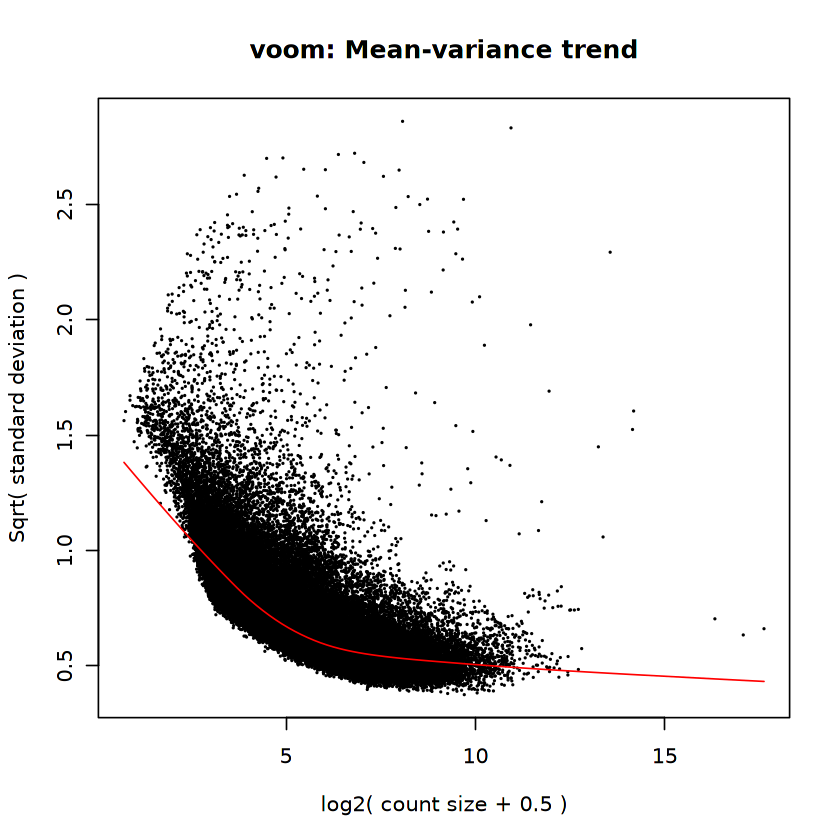

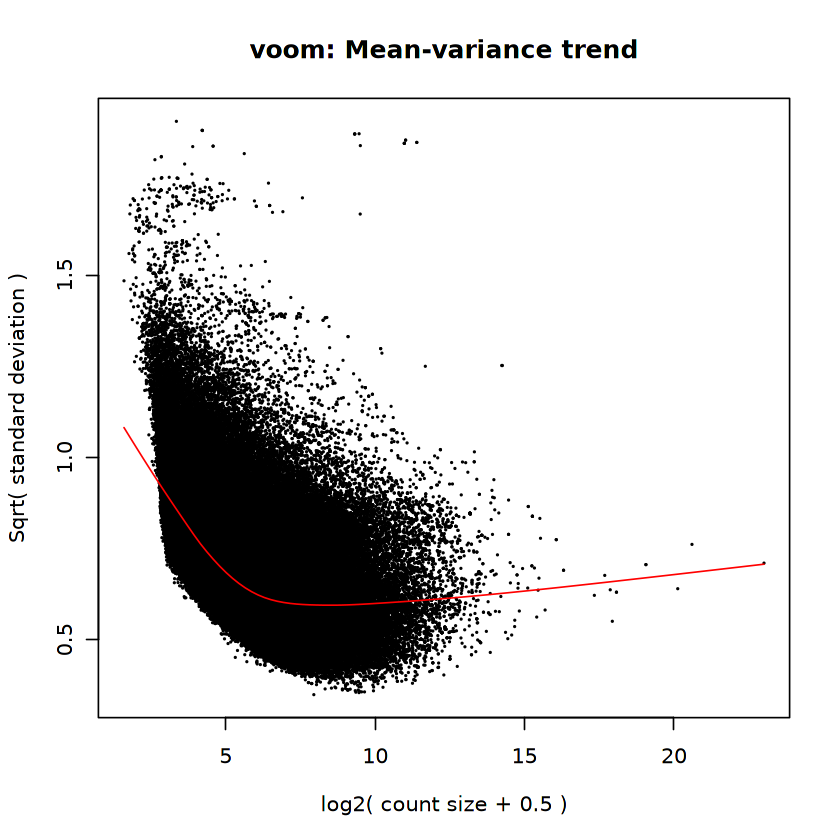

In [4]:
groups = c('szVctl')
for(feature in c('genes', 'transcripts', 'junctions', 'exons')){
    dir.create(feature)
    # Preform voom
    v <- memo_voom(feature)
    save(v, file=paste0(feature,'/voomSVA.RData'))
    # Fit model and apply eBayes
    efit = memo_efit(feature)
    # Save differential expression
    for(group in seq_along(groups)){
        print(groups[group])
        extract_de(group, groups[group], efit, feature)
    }
    # Calculate residuals
    memo_res(feature)
}

## Repreducibility Information

In [5]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-07-13 13:31:27 EDT"

    user   system  elapsed 
6584.970 2464.704 1511.234 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-07-13                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package              * version  date       lib source        
 annotate               1.68.0   2020-10-27 [1] Bioconductor  
 AnnotationDbi          1.52.0   2020-10-27 [1] Bioconductor  
 assertthat             0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports              1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc              0.1-3    2015-07-28 [1] CRAN (R 